# Classification

The goal is to build a classification model to predict if median housing prices in some districts are below or above a certain level (150000).

# Data Import

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns 

In [2]:
# seaborn settings
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

df = pd.read_csv("ready_data.csv")

datatypes_toChange = {"priceCat": "category", "proximity": "category"}
df = df.astype(datatypes_toChange)

# Vorgehensweise

Der nachstehende Pairplot zeigt nocheinmal eine grobe Zusammenfassung aus den Aktivitäten zur Datenvorbereitung in Data.ipynb. Die Darstellung enthält einige Plots, welche ignoriert werden können. Relevant sind die Dichte-Funktionen und deren Überlagerung.

In data.ipynb hatte sich bereits gezeigt, dass die Personen pro Haushalt, Anzahl der Räume, Anteil der Schlafzimmer und das Alter des Gebäudes für die beiden Kategorien *above* oder *below* gleichverteilt sind. D.h. für die Klassifikation wird kein Einfluss erwartet.

Die Modellierung wird entsprechend auf das Median-Einkommen und die Lage (Küste oder Inland) beschränkt.

In den nachfolgenden Stichpunkten wird die Klassifikation jeweils einmal mit **SK Learn** und **Statsmodels** durchgeführt.</br>
Dabei sind unterschiedliche Vorgehensweisen bzgl. Einlesen und Umgang mit Dummyvariablen zu beachten.

* SK Learn verwendet OneHotEncoding in der Pipeline
* Für Statsmodels werden Dummies über eine Pandas-Methode abgerufen

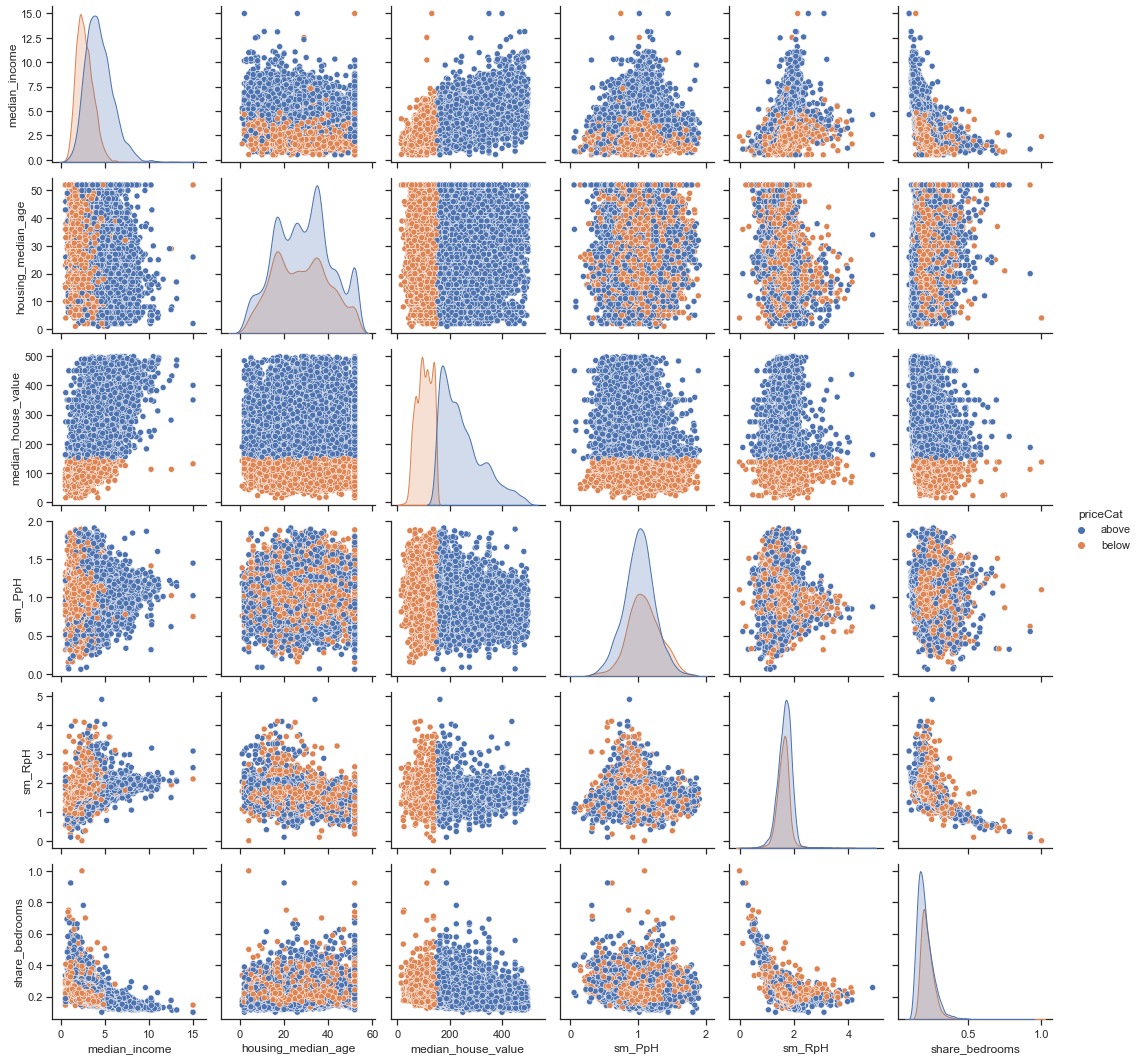

In [3]:
df_smallplot = df[["median_income", "housing_median_age", "median_house_value", "sm_PpH", "sm_RpH", "share_bedrooms", "priceCat"]]
sns.pairplot(hue="priceCat", data=df_smallplot)

# Modellierung in SK Learn Pipeline

Im Folgenden werden über die Pipeline zwei Confusion-Matrix erzeugt. Einmal mit Lage und Einkommen und einmal nur mit Lage.

Die Berücksichtigung der Median-Einkommen in den Distrikten verbessert die Accuracy deutlich. Bei einem Schwellenwert von 0,5.

In [4]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [5]:
y = pd.get_dummies(df[["priceCat"]], drop_first = True)
y = y.priceCat_below
X = df.drop(columns=["priceCat","housing_median_age", "median_house_value", "share_bedrooms", "person_per_household", "rooms_per_household", "sm_PpH", "sm_RpH"], axis=1)
print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19374 entries, 0 to 19373
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   median_income  19374 non-null  float64 
 1   proximity      19374 non-null  category
dtypes: category(1), float64(1)
memory usage: 170.5 KB
None


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 1)

In [7]:
column_trans = make_column_transformer((OneHotEncoder(),["proximity"]), remainder="passthrough")
logreg = LogisticRegression(penalty="l2")

In [8]:
pipe = make_pipeline(column_trans, logreg)
#cross_val_score(pipe,X_train,y_train,cv=5, scoring="accuracy").mean()

In [9]:
y_pred = pipe.fit(X_train, y_train).predict(X_test)
pred_proba = pipe.predict_proba(X_test)

### Zur nachstehenden ConfusionMatrix

Precision und Recall sind etwa gleich auf, weshalb ohne weitere Informationen zu Kosten der Fehlklassifikation keine Anpassung mit Threshold erfolgt.</br>
Der F1 Score kann interpretiert werden, jedoch scheint die Verteilung True Negative zu True Positiv nicht zu verzerrend.</br>

Das Modell predicted mit 1 die Klasse *below* (Positiv)</br>D.h. 1643 Distrikte wurden korrekt als *below* klassifiziert, also unter einem Median-Immobilienwert von 150 T$ (inkl. Obergrenze).

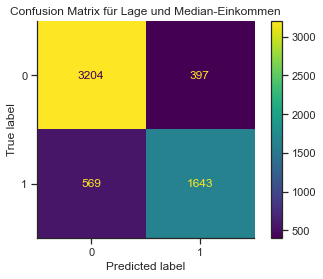

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      3601
           1       0.81      0.74      0.77      2212

    accuracy                           0.83      5813
   macro avg       0.83      0.82      0.82      5813
weighted avg       0.83      0.83      0.83      5813



In [10]:
df_ = pd.DataFrame({'y_test': y_test, 'y_pred': pred_proba[:,1] > .5})
cm = confusion_matrix(y_test, df_['y_pred'])

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=pipe.classes_)
disp.plot()
plt.title("Confusion Matrix für Lage und Median-Einkommen")
plt.show()

print(classification_report(y_test, df_['y_pred']))

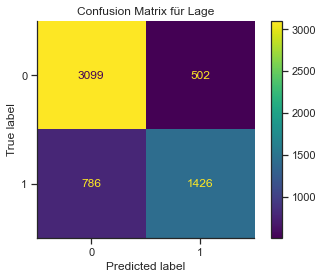

              precision    recall  f1-score   support

           0       0.80      0.86      0.83      3601
           1       0.74      0.64      0.69      2212

    accuracy                           0.78      5813
   macro avg       0.77      0.75      0.76      5813
weighted avg       0.78      0.78      0.78      5813



In [11]:
X_train = X_train.drop("median_income", axis=1)
X_test = X_test.drop("median_income", axis=1)
cross_val_score(pipe,X_train,y_train,cv=5, scoring="accuracy").mean()
y_pred = pipe.fit(X_train, y_train).predict(X_test)
pred_proba = pipe.predict_proba(X_test)
df_ = pd.DataFrame({'y_test': y_test, 'y_pred': pred_proba[:,1] > .5})
cm = confusion_matrix(y_test, df_['y_pred'])

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=pipe.classes_)

disp.plot()
plt.title("Confusion Matrix für Lage")
plt.show()

print(classification_report(y_test, df_['y_pred']))

# Modellierung in Statsmodels

Nachfolgend die Modellierung in Statsmodels. Wegen dem Fehlen der komfortablen Pipeline nur für das Predictor-Paar Lage und Median-Einkommen.

Es ergibt sich eine Accuracy von 78%. Die deutliche Verschlechterung im Vergleich zu SK Learn kann an dem unterschiedlichen Split in Trainings- und Testdaten liegen.

In [12]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [13]:
dummies = pd.get_dummies(df[["proximity","priceCat"]], drop_first = True)
dummies

,proximity_INLAND,priceCat_below
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
19369,1,1
19370,1,1
19371,1,1
19372,1,1


In [14]:
X = pd.concat([df, dummies[["proximity_INLAND", "priceCat_below"]]], axis=1)
numeric_feature_names = X.drop(columns=["proximity_INLAND","priceCat_below"],axis=1).columns

# Entweder mit oder ohne median_income
#X = X.drop(columns=["priceCat","proximity","housing_median_age", "median_house_value", "share_bedrooms", "person_per_household", "rooms_per_household", "sm_PpH", "sm_RpH"], axis=1)
X = X.drop(columns=["median_income","priceCat","proximity","housing_median_age", "median_house_value", "share_bedrooms", "person_per_household", "rooms_per_household", "sm_PpH", "sm_RpH"], axis=1)

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19374 entries, 0 to 19373
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   proximity_INLAND  19374 non-null  uint8
 1   priceCat_below    19374 non-null  uint8
dtypes: uint8(2)
memory usage: 38.0 KB


In [15]:
train_dataset = X.sample(frac=0.8, random_state=0)
test_dataset = X.drop(train_dataset.index)

y_train = train_dataset["priceCat_below"]
y_test = test_dataset["priceCat_below"]
X_train_dataset = train_dataset.drop(["priceCat_below"], axis=1)
X_test_dataset = test_dataset.drop(["priceCat_below"], axis=1)

In [16]:
logit = sm.Logit(y_train, X_train_dataset).fit()

Optimization terminated successfully.
         Current function value: 0.532092
         Iterations 5


In [17]:
data = pd.DataFrame()
data['Probability'] = logit.predict(X_test_dataset)

In [18]:
data['priceCat_below'] = np.where(y_test == 1.0, 'Yes', 'No')  
data['Threshold 0.5'] = np.where(data['Probability'] > 0.5, 'Yes', 'No')  
data.head(7)

,Probability,priceCat_below,Threshold 0.5
10,0.5,No,No
13,0.5,No,No
19,0.5,No,No
26,0.5,Yes,No
40,0.5,No,No
43,0.5,No,No
52,0.5,Yes,No


In [19]:
def print_metrics(df, predicted):
    # Header
    print('-'*50)
    print(f'Metrics for: {predicted}\n')
    
    # Confusion Matrix
    y_actu = pd.Series(df['priceCat_below'], name='Actual')
    y_pred = pd.Series(df[predicted], name='Predicted')
    df_conf = pd.crosstab(y_actu, y_pred)
    display(df_conf)
    
    # Confusion Matrix to variables:
    pop = df_conf.values.sum()
    tp = df_conf['Yes']['Yes']
    tn = df_conf['No']['No']
    fp = df_conf['Yes']['No']
    fn = df_conf['No']['Yes']
    
    # Metrics
    accuracy = (tp + tn) / pop
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * ((precision * recall) / (precision + recall))
    print(f'Accuracy:  {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall:    {recall:.4f}')
    print(f'F1 Score:  {f1_score:.4f} \n')
    
print_metrics(data, 'Threshold 0.5')

--------------------------------------------------
Metrics for: Threshold 0.5



Predicted,No,Yes
Actual,,
No,2102,301
Yes,522,950


Accuracy:  0.7876
Precision: 0.7594
Recall:    0.6454
F1 Score:  0.6978 

